# Lab 2: Logistic Regression & Linear Regression

This lab will teach you how to build both a logistic regression and linear regression framework that you saw in class. Although these common algorithms can be utilized very quickly using pre-built functions provided by packages such as **scipy** and **pandas**, here we abstract the task by focusing on the algorithms used in these frameworks. 

To accomplish this, all the data has already been processed and provided to you so that the whole task can be done only using **numpy**. The only package that you need which was not used in the previous lab is **pickle**. Most python installations will come with pickle, so there is no need to create a new environment for this lab. 





## Lab Overview
### I. Data Processing

### II. Logistic Regression (2 classes of MNIST digits)
- Sigmoid
- Negative Log Likelihood
- Using Gradient Descent to solve Logistic Regression

### III. Linear Regression (USA housing data)
- Mean Squared Error
- Using Gradient Descent to solve Linear Regression
- Closed form solution of Linear Regression

### You are responsible for finishing the functions provided to you in cells:
- **Cell 11**: compute_loss()
- **Cell 14**: GD()
- **Cell 20**: compute_loss()
- **Cell 22**: GD()

In [191]:
import pickle
import numpy as np
import os

### I. Data Processing

There are many ways to read and write data in python. One of the easiest (although not always efficient)
ways to do this is to use [**pickle**](https://docs.python.org/3/library/pickle.html). I have already provided you with data that was pickled into a file (extension .p). Since the file should be located in the same location relative to this .ipynb jupyter lab, we can access it procedurally by first finding our current working directory. 

In [192]:
cwd = os.getcwd()
# display your current working directory
print(cwd)
# define the relative paths of the files we want
mnist_path = '/data/mnist.p'
housing_path = '/data/housing.p'

c:\Users\GeffenPC\Documents\ECE194E\ECE194E\lab2


For your convenience, the data needed for this lab has been procesed into a [python dictionary](https://docs.python.org/3/tutorial/datastructures.html), where each value is a numpy array.  

You can think of **dictionaries** as hash tables, or hash mappings, where each element (value) in the dictionary has a unique hash (key) associated with it. By nature, they are mutable data types (same as lists). In python, dictionary keys can be almost anything, or more specifically they have to be immutable objects (sets, integers, strings, even custom objects...) They are inducive to readable and efficient code due to the provided functionality of python and the versatility of hash maps respectively. Although they are not always the best data structure to use, some things are done much faster with dictinoaries. For example:

Say I am recording some user data where my job is to keep track of the total score for every user. I have some list of user entires, where I have the username and the score for each user as an input. At any given point a new user can join by submitting their score. How would I efficiently keep track of all their scores given that I do not know the full set 
of users before hand?

 Dictionaries are perfect for this. 



In [193]:
# example data
d = {}
user_entries = [['kyle',5],['neeli',3],['jen',2],['kyvaune',3],['kyle',1]]
# If else loop checking keys specifically
for entry in user_entries:
    if entry[0] in d.keys():
        d[entry[0]] += entry[1]
    else:
        d[entry[0]] = entry[1]
print(d)

# Or using a try/except block
d = {}
user_entries = [['kyle',5],['neeli',3],['jen',2],['kyvaune',3],['kyle',1]]

for entry in user_entries:
    try:
        d[entry[0]] += entry[1]
    except:
        d[entry[0]] = entry[1]
print(d)

{'kyle': 6, 'neeli': 3, 'jen': 2, 'kyvaune': 3}
{'kyle': 6, 'neeli': 3, 'jen': 2, 'kyvaune': 3}


Below we load in the data using pickle's load function. Note 'rb' is used to declare that we are 'reading' the file. 

In [194]:
data = pickle.load(open(cwd+mnist_path,'rb'))
# data is a dictionary
print(data.keys())
for key in data.keys():
    print(key, data[key].shape)

dict_keys(['x_test', 'y_test', 'x_train', 'y_train'])
x_test (1967, 28, 28)
y_test (1967,)
x_train (11867, 28, 28)
y_train (11867,)


[MNIST](http://yann.lecun.com/exdb/mnist/) is a well known dataset of handwritten digits containing 60,000 training images and 10,000 testing images. The dataset comes labeled, with a total of 10 classes (one for each digit.) For our task, I have preprocessed the data by taking all examples corresponding to the digits 6 and 9. My intuition is that these two digits should be easy to distinguish between..., can you guess why?

The images in MNIST are 28 by 28 pixels. Hence the x_test and x_train datasets are numpy arrays of dimension (N, 28, 28) where N is the number of samples. Note how the testing set is smaller than the training set, this is common practice. 

The labels in MNIST are integers corresponding to the digits. Since we are working with binary logistic regression, we want our labels (or targets), to be zero or one. Hence I have re-labeled the datset for you so that **six corresponds to a label of zero and nine corresponds to a label of one.**

x_test - Dataset of MNIST digit images (6 and 9) to be used for testing.

y_test - Dataset of MNIST digit labels (0 and 1) to be used for testing.

x_train - Dataset of MNIST digit labels (6 and 9) to be used for training.

y_train - Dataset of MNIST digit labels (0 and 1) to be used for training.



Using [rcParams](https://matplotlib.org/stable/tutorials/introductory/customizing.html)
 provided by matplotlib makes it easier to control your plots. 



In [195]:
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib as mpl
# colors used
ORANGE = '#FF9132'
TEAL = '#0598B0'
GREEN = '#008F00'
PURPLE = '#8A2BE2'
GRAY = '#969696'
FIG_WIDTH = 4
FIG_HEIGHT = 3

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "DejaVu Sans",
    "font.serif": ["Palatino"],
    "font.size": 12,
    "axes.titlesize": 15,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "lines.linewidth": 2
})

We can create a function that will display our MNIST digits for us

In [196]:
def imshow_mnist(img, labels):
    # -1 is used to imply a dimension 
    img = img.reshape(-1,28)
    plt.imshow(img, cmap='gray')
    ticks = np.arange(14,img.shape[0],28)
    # plt.yticks(ticks=ticks ,labels=labels)
    plt.yticks(ticks ,labels)
    plt.xticks([])
    plt.show()

[Lambda expressions](https://docs.python.org/3/tutorial/controlflow.html) can be useful in python when we want to define small expressions. 

In [197]:
get_label = lambda x : 6 + 3*x
print(get_label(np.array([0,1,1])))

[6 9 9]


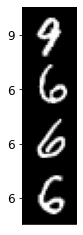

In [198]:
imshow_mnist(data['x_train'][0:4],get_label(data['y_train'][0:4]))

### II. Logistic Regression

Logistic Regression is a classification algorithm used to differentiate data into discrete classes. The simplest form of this algorithm is the binary setting, where we have only two classes, $0$ and $1$. 

Given a dataset $\mathcal{X}=\{x_1,x_2,\ldots,x_N\}$ of $d$-dimensional vectors $x$, we have a corresponding set of labels $\mathcal{Y}=\{y_1,y_2,\ldots,y_N\}$ where  $y_i\in\{0,1\}$. Our job is to build a classifier $h_{\theta}$ that can calculate the probability a given $x$  belongs to class $1$, sometimes thought of as "success". We can think of this probability as a score, where our classifier outputs an estimate $0\leq h_{\theta}(x)\leq1$. So what is $\theta$ and what kind of function is our classifier $h_{\theta}$?

$$h_{\theta}=\sigma(\theta^\intercal x).$$

We can see that $\theta$ is a $d$-dimensional vector that maps our input vector $x$ to a real number. This is done in linear regression to map our data to a continous value, but since we want a probability of belonging to a given class we can not stop here. This is where the sigmoid function comes in, we use it to map this value between zero and one. 
$$\sigma(x)=\frac{1}{1+e^{-x}}$$

Why would such a function be used here, let's take a look at it. 

In [199]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

Play around with the x_min, x_max values below and see what it looks like.


We can see that it is quite sensative to the range, with its behaviour going from a step function to a line. 

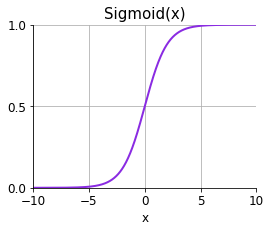

In [200]:
x_min, x_max = -10, 10
# x_min, x_max = -1,1
# x_min, x_max = -1000,1000

x = np.arange(x_min,x_max,0.01)

fig, axs = plt.subplots(1,1,figsize=(FIG_WIDTH,FIG_HEIGHT))
axs.plot(x,sigmoid(x),color=PURPLE)
plt.title('Sigmoid(x)')
axs.set_xlabel('x')
axs.set_xlim(x_min,x_max)
axs.set_ylim(0,1)
axs.set_yticks([0,0.5,1])
axs.grid()
plt.show()

The sigmoid function shown above outputs a probability value between $0$ and $1$ given a real value as an input. In the scope of binary logistic regression, our input is some data sample $x\in\mathcal{X}$, which has a corresponding true label $y$. We can think of the overall classifier as such:
$$
\begin{align} 
h_{\theta}(x) &= P(y=1|x,\theta),\\
1-h_{\theta}(x) &= P(y=0|x,\theta),\\
\end{align}
$$
where we predict that our data sample $x$ is in class $y=1$ if $h_{\theta}(x)\geq 0.5$.

How would we train such a classifier, or better yet, how do we choose $\theta$ so that our classifier is as best as it can be? If we knew how $x$ was distributed based on the label, we can solve this problem exactly using Baye's rule and what we  have learned about the Maximum Likelihood Estimate. But in this case, we are not given any information on how $x$ is distributed, and hence must learn the right $\theta$ some other way. To do this, we must first build a metric that desides how good a given choice of $\theta$ is at classifying our data. A general metric is shown below:

$$
J(\theta) = \frac{1}{N}\sum_{i=1}^{N}cost(h_{\theta}(x_i),y_i)
$$

So given a datset $\mathcal{X}$, we can sum over the individual data points $x_i$, checking how close our predicted label $h_{\theta}(x_i)$ is to the true target $y_i$ for each data point. You can see that this depends on not only the chosen value of $\theta$, but also the dataset $\mathcal{X}$. What should the cost be in this expression? Since we are working with probability values we use the log likelihood loss function, where:
$$
cost(h_{\theta}(x),y)= \begin{cases} -log(h_{\theta}(x)) \ &\text{if} \ y=1 \\ -log(1-h_{\theta}(x)) \ &\text{if} \ y=0  \end{cases}
$$


The intuition here is that the log function discounts greatly if we are far away from the true label, and less so when we are close. But this is not so convenient for us, as we do not want to deal with this conditional switching in our overall loss function $J(\theta)$. Luckily, a simpler cost function can be defined, that still has the same value as the expression above:
$$
cost(h_{\theta}(x),y)= -y log(h_{\theta}(x)) - (1-y)log(1-h_{\theta}(x))
$$

Your first task is to construct the defined loss function, $J(\theta)$, in the cell below. Remember that $J$ acts on a given dataset $\mathcal{X}$. Sometimes it is easier to think of our dataset as an $N$ by $d$ matrix, since this is how we work with it in python/numpy. 

$$
X=
\begin{bmatrix}
x_0\\
x_1\\
\vdots\\
x_N
\end{bmatrix}
$$

Remember that $N$ is the size of the dataset, and $d$ is the dimension of each data sample $x$. Since MNIST is a dataset of images, we want to flatten the image vectors before passing them along to our loss function. 

In [201]:
def compute_loss(x, y, theta):
    '''
    Computes the Negative Log-Likelihood Loss
    Inputs:
        x     - np.array of MNIST digits size (N,28,28) or (28,28)
        y     - np.array of labels 0 for 'six' and 1 for 'nine'
        theta - np.array of the parameter vector we want to learn
        
    HINT: The computer does not like log(0)
    '''
    
    # reshape the dataset to be (N,d) where N = number of samples, d = 28*28
    x = x.reshape(-1,28*28)
    N = len(x)

    # define some epsilon value to avoid log(0), ideally sigmoid should never
    #  return 0 exactly but we have finite precision
    eps = np.finfo(float).eps

    # # model output for every sample --> (N,1)
    h_theta = sigmoid(np.dot(x,theta))

    # total cost over all samples, y --> (N,1) do inner product for multiplication to get scalar loss
    cost = -np.dot(y,np.log(h_theta+eps)) - np.dot((1-y),np.log((1-h_theta)+eps))
    
    # average over all samples
    return cost/N

After building the above function, lets check that it works both on individual data samples from our MNIST dataset, and for subsets of the dataset. 

In [202]:
rng = np.random.default_rng(seed=123)
theta = rng.random(28*28)
x = data['x_train'][0].flatten()
y = data['y_train'][0]
print(compute_loss(x,y,theta))

[1.23725587e-05]


In [203]:
x = data['x_train']
y = data['y_train']
print(compute_loss(x,y,theta))

16.186200900463472


Given our fancy loss function $J(\theta)$, how do we now use it to choose $\theta^*$, the best $\theta$. We want a $\theta^*$ that minimizes our loss function when evaluated over the entire dataset, which in our case is the training set provided. 

$$
\theta^* = \arg\min_{\theta} J(\theta)
$$

Okay so lets just use what we know from calculus, we take the derivative of $J$ with respsect to $\theta$, set that to zero and then... oh wait. If you go about this route, you will see that unless we had a closed form differentiable expression for $P(y|x)$, we can not solve the problem this way. Instead we rely on a famous numerical technique known as Gradient Descent (GD). 

GD assumes the given function is convex (you can think of that as meaning it only has one global minimum), and goes about finding the minimum value of the function. Essentially you can think of it as taking steps in the direction of the negative derivative (downhill), until it reaches the bottom of our function. So at every iteration of GD, we can update our current estimate of the paramater $\theta$, by taking a step in the direction of the negative derivate (gradient) of $J(\theta)$:

$$
\theta : \theta -\alpha \frac{\delta}{\delta\theta}\Big[J(\theta)\Big],
$$

where $\alpha$ is the size of the steps we take. Intuitively, GD asks "which elements of $\theta$ can I tune so that our loss evaluated over the entire dataset decreases?". A larger gradient in those elements of $\theta$ corresponds to the loss being more sensetive in those dimensions. As we continue to iterate and update $\theta$ in this fashion, we are gauarnteed to reach the global minimum given that our function $J$ is convex. Even though our function may be highly non-convex, this approach is computationally efficient, and hence is used widely even in more complex settings such as Neural Networks, where there are no such gaurantees. 

For logistic regression, the gradient of $J$ is computed for you and shown below. For linear regression in the next part, it will be your job. 

$$
\begin{align}
\frac{\delta J}{\delta \theta} &= \frac{\delta}{\delta \theta}\Big(\frac{1}{N}\sum_{i=1}^{N}cost(h_{\theta}(x_i),y_i)\Big),\\
&= \frac{1}{N}\sum_{i=1}^{N}\frac{\delta}{\delta \theta}cost(h_{\theta}(x_i),y_i),\\
\end{align}
$$

where

$$
\begin{align}
\frac{\delta \ cost(h_{\theta}(x_i),y_i)}{\delta \theta} &= \frac{\delta}{\delta \theta}\Big(-y log(h_{\theta}(x)) - (1-y)log(1-h_{\theta}(x))\Big).\\
\end{align}
$$

Given that $\frac{\delta}{\delta x}\sigma(x) = \sigma(x)(1-\sigma(x))$ one can show:

$$
\begin{align}
\frac{\delta J}{\delta \theta[j]} &= \frac{1}{N}\sum_{i=1}^{N}\big((h_{\theta}(x_i)-y_i)x_i[j]\big)
\end{align}
$$

Note the indexing over the elements of $\theta$ which is needed when computing the gradient vector. The $j$ here denotes the dimension of $\theta$ at which we are evaluating this partial derivative, and hence we use the $j$'th element of datasamples $x_i$ to weight our derivative. 

Your task is to implement a Graident Descent algorithm that utilizes this gradient to make updates to a given $\theta$ for some pre defined number of iterations. Most of the code is provided to you, so your task is to finsh the given function.

In [204]:
def GD(x, y, theta, lr, num_iters):
    '''
    Computes gradient descent to minimize the NLL
    Inputs:
        x         - np.array of MNIST images
        y         - np.array representing the true labels
        theta     - np.array of the parameter vector we want to learn (initial guess)
        lr        - learning rate or step size 
        num_iters - number of steps we take
    '''
    # we will want x to be in the right format
    x = x.reshape(-1,28*28)
    N = len(x)
    # we may also want to store the computed loss as we iterate
    loss = np.zeros(num_iters)

    for i in range(num_iters):
        # compute the loss for this iteration ()total loss so average it)
        loss[i] = compute_loss(x,y,theta)

        # calculate the output (used by gradient)
        h_theta = sigmoid(np.dot(x,theta))

        # calculate the gradient (average over all samples)
        dj_dtheta = (1/N)*np.dot((h_theta-y),x)

        # update the parameters
        theta = theta - lr*dj_dtheta

    return loss, theta

Given our learned value of $\theta^*$, we want to make some predictions on the unseen data in our test dataset. This is commonly used as a metric for classification problems, since testing on the same dataset you train on can give biased results. 

In [205]:
def predict(x, theta):
    return np.round(sigmoid(np.dot(x.reshape(-1,28*28),theta)))

Here we can test your gradient descent implementation. Is your loss improving (decreasing) as you iterate? Note the chosen value for learning rate and number of iteration can be changed, although it should work as is. 

Initial Cost is: 14.889


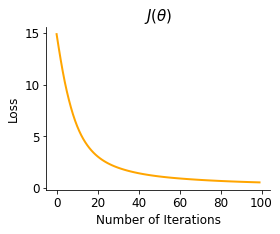

In [206]:
x = data['x_train']
y = data['y_train']

num_iters = 100
lr = 0.1
theta = rng.random(28*28)
print("Initial Cost is: %.3f"%compute_loss(x, y, theta))

loss, theta_star = GD(x, y, theta, lr, num_iters)

fig, axs = plt.subplots(1,1,figsize=(FIG_WIDTH,FIG_HEIGHT))
axs.plot(range(len(loss)), loss, 'ORANGE')
plt.title("$J(\\theta)$")
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.show()



If the above plot of our loss fucntion looks like it has converged, we can see how our accuracy is on the test dataset. The solution should result in an accuracy of above 95%. We can also look at the some of the misclassified images to get a sense of what caused the classification errors. 

Accuracy on test set: 96.950


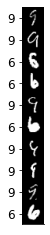

In [207]:
x = data['x_test']
y = data['y_test']

y_predict = predict(x, theta_star)
print("Accuracy on test set: %.3f"%(np.mean(y_predict==y)*100))
imshow_mnist(x[y_predict!=y][0:10],get_label(y[y_predict!=y][0:10]))

### III. Linear Regression (USA housing data)

Now that we have looked at logistic regression, I will let you implement a multi-class linear regression framework. A lot of the theory is the same here, but the main difference is in the cost function used to evaluate how close the predicted values are to the true ones. Remember that in linear regression, we are trying to estimate a continous value, and hence we do not need to use a sigmoid in order to map our values to probabilities. Instead, we rely on the Mean Squared Error as our metric of cost, and sum this error over the whole dataset given a $\theta$.

$$
J(\theta) = \frac{1}{2N}\sum_{i=1}^{N}(\theta^\intercal x_i -y_i)^2,
$$

where the inner summation is the Mean Squared Error between the true value $y_i$, and our prediction $\theta^\intercal x_i$. 

Just like in the previous task, your job is to construct a linear regression framework using gradient descent by computing the gradient of the above loss function. The dataset we will work with is the USA housing dataset. It has been converted for you in the same manner, split into training and testing datasets of labels and features.  

Each data sample $x$ is a row of the full data set $X$, where the 'features' are the columns of $X$. In this dataset, there are five features:

 0     Avg. Area Income              

 1     Avg. Area House Age           

 2     Avg. Area Number of Rooms     

 3     Avg. Area Number of Bedrooms  

 4     Area Population 

The provided labels give the corresponding house's price for each data sample $x$. Your job is to create a linear function $\theta^\intercal x$, that can estimate house prices. This is the standard linear regression setting.  



In [208]:
data = pickle.load(open(cwd+housing_path,'rb'))
print(data.keys())
for key in data.keys():
    print(key, data[key].shape)

dict_keys(['x_train', 'y_train', 'x_test', 'y_test'])
x_train (4500, 5)
y_train (4500,)
x_test (500, 5)
y_test (500,)


The features vary greatly in their distribution, since they are not just pixel values. The number of bedrooms is a good dictator of home price, but its magnitude is small compared to the average income in the neighberhood. Because of this, we first normalize the individual features, so that they have the same weight. Also, since we want to account for a bias term (think of zero-intercept in 2-dimensions,) we can do this directly by injecting $1$ as the first feature of every data point $x$.

In [209]:
def normalize(x):
    '''
    Normalizes the input data and add ones column for bias
    '''
    new_x = np.ones((len(x),6))
    for col in range(x.shape[1]):
        new_x[:,col+1] = (x[:,col]-x[:,col].mean())/x[:,col].std()

    return new_x

Your task is as before, finish the function below. 

In [210]:
def compute_loss(x, y, theta):
    '''
    Computes the MSE or L2 loss
    Inputs:
        x     - np.array of arbitrary length and width of 6
        y     - np.array representing true housing price
        theta - np.array of the parameter vector we want to learn
    '''
    
    # get the dataset length
    N = x.shape[0]

    # compute the loss over all samples
    loss = (1/(2*N))*np.sum(np.square(np.dot(x,theta)-y))
    
    return loss

Does your function work?

In [211]:
x = normalize(data['x_train'])
y = data['y_train']

theta = rng.random(6)
print(compute_loss(x,y,theta))

# square root gives more intuitive value ~1,000,000
print(np.sqrt(compute_loss(x,y,theta)))

824456720792.9413
907995.9916172215


Now do the same as before, constructing the gradient descent algorithm for linear regression by taking steps in the direction of the negative gradient of $J(\theta)$ with respect to theta.

### Deriving the gradient:
$$
J(\theta) = \frac{1}{2N}\sum_{i=1}^{N}(\theta^\intercal x_i -y_i)^2,
$$

$$
\frac{\partial J}{\partial \theta_j} = \frac{\partial}{\partial \theta}\Big(\frac{1}{2N}\sum_{i=1}^{N}(\theta^\intercal x_i -y_i)^2\Big)
$$

$$
\frac{\partial J}{\partial \theta_j} = \frac{1}{N}\Big(\sum_{i=1}^{N}(\theta^\intercal x_i -y_i)\Big)x_i[j]
$$

Overall the gradient then can be expressed in vector notation:
$$
\nabla J(\theta) = \frac{1}{N}(X\theta-y)X
$$

In [212]:
def GD(x, y, theta, lr, num_iters):
    '''
    Computes gradient descent to minimize the MSE
    Inputs:
        x         - np.array of arbitrary length and width of 5
        y         - np.array representing true housing price
        theta     - np.array of the parameter vector we want to learn
        lr        - learning rate or step size 
        num_iters - number of steps we take

    HINT: Dont forget that we normalize(x) before passing it into this function,    
          which adds an extra dimension to our data.
    '''
    # your code goes here
    cost = np.zeros(num_iters)
    N = len(x)

    for i in range(num_iters):
        # get the current cost
        cost[i] = compute_loss(x,y,theta)

        # find the gradient
        grad = (1/N)*np.dot((np.dot(x,theta)-y),x)

        # update the parameters
        theta = theta -lr*grad
    return cost, theta

In [213]:
def predict(x, theta):
    return np.dot(x.reshape(-1,6),theta)

Lets see how your algorithm preforms. I have chosen arbitrary values for num_iters and learning rate, play around with them.

Initial Cost is: 824456803768.559


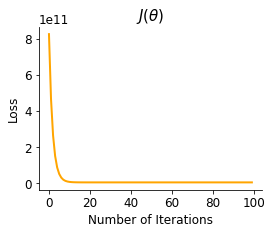

In [214]:
x = normalize(data['x_train'])
y = data['y_train']

#play around with these values
num_iters = 100 # set this to converge to ideal loss using closed form
lr = 0.25
theta = rng.random(6)
print("Initial Cost is: %.3f"%compute_loss(x, y, theta))

cost, theta = GD(x, y, theta, lr, num_iters)

fig, axs = plt.subplots(1,1,figsize=(FIG_WIDTH,FIG_HEIGHT))
axs.plot(range(len(cost)), cost, 'ORANGE')
plt.title("$J(\\theta)$")
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.show()



Unlike logistic regression, linear regression has a closed form solution (when we set the gradient to zero) given a data matrix $X$. In 2-dimensions you may recall this closed form solution as finding the best-fit line for a dataset. The math in d-dimensions is almost identical but relies on taking the L2 norm between the predictions of the dataset $X\theta$ (this is a column vector of dimension $N$), and all of our labels $y$ (also a column vector).

$$
\theta^* = (X^\intercal X)^{-1}X^\intercal \mathbf{y},
$$
where boldfaced $\mathbf{y}$ is used to denote that we are referring to the whole dataset, and hence we need the full vector of labels. 

The closed form solution for $\theta^*$ is provided below as "true_theta". We can compare our loss to this solution to see how close we are.

In [215]:
temp = np.matmul(x.T,x)
inv = np.linalg.inv(temp)
true_theta = np.dot(np.matmul(inv,x.T),y)

print("Loss after running lin reg with gradient descent: %.3f"%compute_loss(x,y,theta))
print("Loss using ideal parameters: %.3f"%compute_loss(x,y,true_theta))

Loss after running lin reg with gradient descent: 5086664120.750
Loss using ideal parameters: 5086664120.749


If these numbers are close, we can move on to see how good our estimator is. 

In [216]:
x = normalize(data['x_test'])
y = data['y_test']

y_predict = predict(x, theta)
# find average error
np.mean(abs(y_predict-y))
print('Average house price: %.3f'%y.mean())
print('Std. of house prices: %.3f'%y.std())
print('Average abs. error of our prediction: %.3f'%np.mean(abs(y_predict-y)))

Average house price: 1214045.125
Std. of house prices: 335494.469
Average abs. error of our prediction: 83465.195


You should see that the average absolute error over the testset is an order of magnitude smaller than the standard deviation of the testset. This means we can make accurate predictions, just by applying a very simple algorithm on our dataset. This of course can be improved on by utilizing more features, constructing different kernels for our features, and using an L-2 penalty as shown in class for ridge-regression. 